**Natalia Castilla Reyes**

**Miguel Angel Quintero**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Instalación dependencias
!pip install --upgrade plotly
!pip install -q findspark
!pip install "dask[array]"       # Install requirements for dask array
!pip install "dask[dataframe]"   # Install requirements for dask dataframe
!pip install "dask[diagnostics]" # Install requirements for dask diagnostics
!pip install "dask[distributed]" # Install requirements for distributed dask

     |████████████████████████████████| 20.6 MB 1.4 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 118 kB 5.0 MB/s 
     |████████████████████████████████| 769 kB 5.3 MB/s 
     |████████████████████████████████| 766 kB 64.4 MB/s 
     |████████████████████████████████| 1.0 MB 70.5 MB/s 
     |████████████████████████████████| 722 kB 54.0 MB/s 
     |████████████████████████████████| 722 kB 71.2 MB/s 
     |████████████████████████████████| 715 kB 75.2 MB/s 
     |████████████████████████████████| 705 kB 66.1 MB/s 
     |████████████████████████████████| 699 kB 69.4 MB/s 
     |████████████████████████████████| 696 kB 41.7 MB/s 
     |████████████████████████████████| 684 kB 69.8 MB/s 
     |████████████████████████████████| 679 kB 76.9 MB/s 
     |████████████████████████████████| 675 kB 71.2 MB/s 
     |████████████████████████████████

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"
#######################SPARK
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz

In [ ]:
#@title Librerias necesarias
#Librerias generales

import time
import math
import datetime

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tqdm
import pickle
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import dask
import joblib
from dask.dataframe import DataFrame as dd
import warnings

#Configuraciones
warnings.filterwarnings("ignore")
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.options.display.max_columns = 400

#########Modelos
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#Tensor Flow

import tensorflow as tf

# importa objetos de keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
print("Versión de Tensorflow: ", tf.__version__)
# optimizador
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping


##Para definir la funcion de perdida que necesitaos en keeras

from keras import backend as K

#Variable global

DAYS_PRED = 28
ruta = "/content/drive/MyDrive/Proyecto_topicos/"

Versión de Tensorflow:  2.5.0


In [ ]:
#@title Funciones Globales
def downcast(df):
  
    """ Esta función nos permite adecuar el tipo de datos que estamos empleando de tal manera que podamos 
        liberar memoria"""

    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

# 5. Modelo LSTM

In [ ]:
##liberamos memoria
#del df #Liberando espacio

data = pd.read_pickle(ruta+'df_lgb.pkl')

data = downcast(data)

###Imputamos los valores nulos.
data = data.replace([np.inf, -np.inf], np.nan)
data.fillna(0, inplace=True)

In [ ]:
# Debemos agrupar los datos en store_id y días para calcular el volumen total de ventas por día y por tienda

data = data[['store_id','d','sold']].groupby(['store_id','d']).sum()

In [ ]:
## Creamos un diccionario donde para cada key está el dataframe correspondiente al volumen de ventas.
d_store_id = {0:'CA_1',1:'CA_2',2:'CA_3',3:'CA_4',4:'TX_1',
              5:'TX_2',6:'TX_3',7:'WI_1',8:'WI_2',9:'WI_3'}
              
dic_data = {}

for key in d_store_id:
  dic_data[d_store_id[key]] = data.xs(key)

dic_data['CA_3'].head()

,sold
d,
1069.0,4320.0
1070.0,5704.0
1071.0,6376.0
1072.0,7044.0
1073.0,7736.0


In [ ]:
## Cada dataframe deberá pasar por el mismo preprocesamiento

scaler = MinMaxScaler(feature_range=(0, 1))

dataset = {}
for i in dic_data:
  scaled_data = scaler.fit_transform(dic_data[i].values)
  dataset[i] = pd.DataFrame(scaled_data,index=dic_data[i].index, columns=['sold_scaled'])

**Creamos los datos de entrenamiento tenemos que realizar 10 modelos, para cada tienda, pues cada tienda tiene un comportamiento diferente**

In [ ]:
## Todos los dataframes se dividen en train y test. Se usa 'CA_1' porque todos los df tienen la misma longitud
train_size = int(len(dataset['CA_1']) * 0.8)
test_size = len(dataset['CA_1']) - train_size

train = {}
test = {}
for i in dataset:
  train[i], test[i] = dataset[i].iloc[0:train_size], dataset[i].iloc[train_size:len(dic_data[i])]
  len_train = len(train[i])
  len_test = len(test[i])
  print(len_train, len_test)

698 175
698 175
698 175
698 175
698 175
698 175
698 175
698 175
698 175
698 175


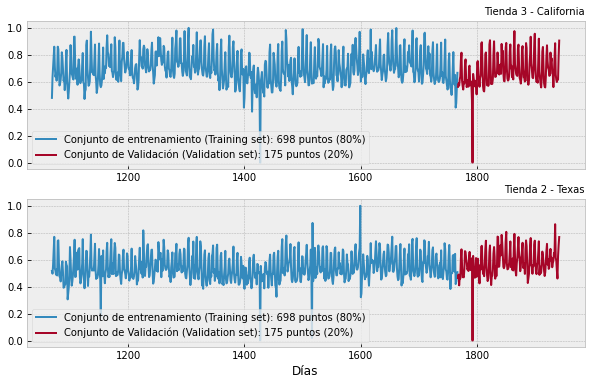

In [ ]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
ax1.plot(train['CA_3'], label='Conjunto de entrenamiento (Training set): ' + str(len_train) +' puntos (80%)')
ax1.plot(test['CA_3'], label='Conjunto de Validación (Validation set): '  + str(len_test) + ' puntos (20%)') 
ax1.set_title("Tienda 3 - California", size = 10,loc='right')
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(train['TX_2'], label='Conjunto de entrenamiento (Training set): ' + str(len_train) +' puntos (80%)')
ax2.plot(test['TX_2'], label='Conjunto de Validación (Validation set): '  + str(len_test) + ' puntos (20%)') 
ax2.set_title("Tienda 2 - Texas", size = 10,loc='right')
ax2.legend()
ax2.set_xlabel('Días')
plt.savefig(ruta+'modelo_LSTM/testval.png', bbox_inches='tight')
plt.show()

In [ ]:
def create_dataset(X, y, time_steps=1):
    # crea dos listas vacias para depositar los datos
    Xs, ys = [], []
    # el primer lote de datos empieza en la primera observación
    # y toma time_steps  datos.
    # Comienza a avanzar hacia adelante.
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 30

X_train = {}
y_train = {}
X_test = {}
y_test = {}
for i in dataset:
  X_train[i], y_train[i] = create_dataset(train[i], train[i], time_steps)
  X_test[i], y_test[i] = create_dataset(test[i], test[i], time_steps)
  print(X_train[i].shape, y_train[i].shape)

(668, 30, 1) (668, 1)
(668, 30, 1) (668, 1)
(668, 30, 1) (668, 1)
(668, 30, 1) (668, 1)
(668, 30, 1) (668, 1)
(668, 30, 1) (668, 1)
(668, 30, 1) (668, 1)
(668, 30, 1) (668, 1)
(668, 30, 1) (668, 1)
(668, 30, 1) (668, 1)


In [ ]:
## definimos la estructura del modelo LSTM
# shapes
inputs_shape = (X_train['CA_1'].shape[1], X_train['CA_1'].shape[2])
lstm_output = 60

# layers
inputs = Input(inputs_shape)
x = LSTM(units=lstm_output, name='LSTM_layer')(inputs)
outputs = Dense(1)(x)

# model
model = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')

In [ ]:
model.summary()

Model: "series_LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 60)                14880     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error',
  optimizer=Adam(0.001)
)

In [ ]:
## Entrenamos cada modelo y cada tensor que retorna keras se guarda en un dict

history = {}
for i in dataset:
  history[i] = model.fit(
      X_train[i], y_train[i],
      epochs=30,
      batch_size=16,
      validation_split=0.1,
      verbose=1,
      shuffle=False
      )
  model.save(ruta+'modelo_LSTM/'+i+'_LSTM.h5')

Epoch 1/30
38/38 [==============================] - 3s 25ms/step - loss: 0.0860 - val_loss: 0.0212
Epoch 2/30
38/38 [==============================] - 1s 14ms/step - loss: 0.0191 - val_loss: 0.0218
Epoch 3/30
38/38 [==============================] - 0s 13ms/step - loss: 0.0186 - val_loss: 0.0212
Epoch 4/30
38/38 [==============================] - 0s 13ms/step - loss: 0.0184 - val_loss: 0.0210
Epoch 5/30
38/38 [==============================] - 1s 13ms/step - loss: 0.0181 - val_loss: 0.0206
Epoch 6/30
38/38 [==============================] - 0s 13ms/step - loss: 0.0177 - val_loss: 0.0196
Epoch 7/30
38/38 [==============================] - 1s 13ms/step - loss: 0.0170 - val_loss: 0.0183
Epoch 8/30
38/38 [==============================] - 0s 13ms/step - loss: 0.0162 - val_loss: 0.0174
Epoch 9/30
38/38 [==============================] - 1s 13ms/step - loss: 0.0153 - val_loss: 0.0164
Epoch 10/30
38/38 [==============================] - 0s 13ms/step - loss: 0.0141 - val_loss: 0.0155
Epoch 11/

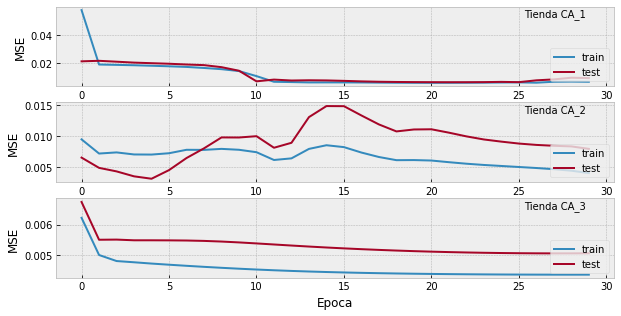

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1,figsize=(10,5))

m=0
for key in history:
      ax[m].plot(history[key].history['loss'], label='train')
      ax[m].plot(history[key].history['val_loss'], label='test')
      ax[m].legend(loc='lower right')
      ax[m].set_xlabel("Epoca")
      ax[m].set_ylabel("MSE")
      ax[m].set_title("Tienda "+key,size = 10,loc='right', x=0.95, y=0.8)
      m+=1
      if m==3:
        break
plt.savefig(ruta+'modelo_LSTM/mseLSTM.png', bbox_inches='tight')
plt.show()

**Predicción de los dato con el modelo LSTM**


In [ ]:
## Finalmente, se hace la predicción de los modelos

y_pred = {}

for i in dataset:
  y_pred[i] = model.predict(X_test[i])

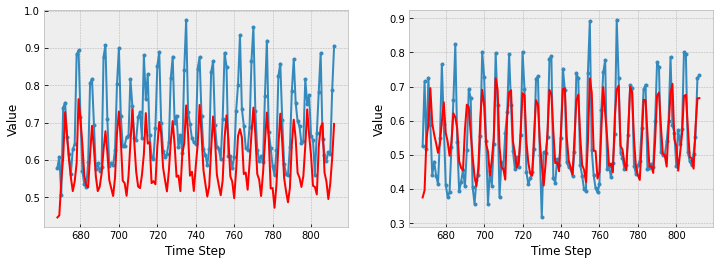

In [ ]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax1.plot(np.arange(len(y_train['CA_3']), len(y_train['CA_3']) + len(y_test['CA_3'])), y_test['CA_3'], marker='.', label="true")
ax1.plot(np.arange(len(y_train['CA_3']), len(y_train['CA_3']) + len(y_test['CA_3'])), y_pred['CA_3'], 'r', label="prediction")
ax1.set_ylabel('Value')
ax1.set_xlabel('Time Step')

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(len(y_train['WI_1']), len(y_train['WI_1']) + len(y_test['WI_1'])), y_test['WI_1'], marker='.', label="true")
ax2.plot(np.arange(len(y_train['WI_1']), len(y_train['WI_1']) + len(y_test['WI_1'])), y_pred['WI_1'], 'r', label="prediction")
ax2.set_ylabel('Value')
ax2.set_xlabel('Time Step')
plt.show()

In [ ]:
for i in dataset:
  y_pred[i] = scaler.inverse_transform(y_pred[i])
  y_test[i] = scaler.inverse_transform(y_test[i].reshape(-1,1))

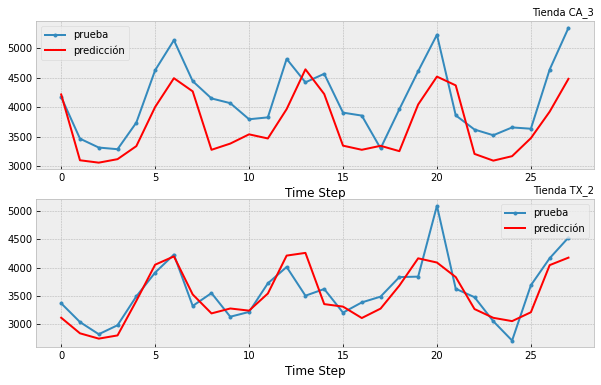

In [ ]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
ax1.plot(y_test['CA_3'][-28:], marker='.', label="prueba")
ax1.plot(y_pred['CA_3'][-28:], 'r', label="predicción")
# ax1.set_ylabel('Value')
ax1.set_xlabel('Time Step')
ax1.set_title("Tienda CA_3",size = 10,loc='right')
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.plot(y_test['TX_2'][-28:], marker='.', label="prueba")
ax2.plot(y_pred['TX_2'][-28:], 'r', label="predicción")
# ax2.set_ylabel('Value')
ax2.set_xlabel('Time Step')
ax2.set_title("Tienda TX_2",size = 10,loc='right')
ax2.legend()

plt.savefig(ruta+'modelo_LSTM/predtestLSTM.png', bbox_inches='tight')
plt.show()

In [ ]:
RMSE_LSTM = {}
for i in dataset:
  rms_LSTM = np.sqrt(np.mean(np.power(y_pred[i]-y_test[i],2)))
  mse_LSTM = mean_squared_error(y_pred[i], y_test[i])
  RMSE_LSTM[i] = rms_LSTM
  # print('Tienda '+i)
  # print("RMS:", rms_LSTM)
  # print("MSE:", mse_LSTM)
  # print()
RMSE_LSTM

{'CA_1': 546.2085,
 'CA_2': 600.7159,
 'CA_3': 588.94476,
 'CA_4': 587.0717,
 'TX_1': 427.37082,
 'TX_2': 350.04486,
 'TX_3': 346.92075,
 'WI_1': 513.4953,
 'WI_2': 563.39087,
 'WI_3': 615.9845}